In [1]:
# --- Section 1: Setup and Imports ---
# This section imports all necessary libraries for data manipulation, text processing,
# machine learning, and visualization.

import pandas as pd
import numpy as np
import re # Regular expression library for text cleaning
import string # For punctuation handling
import os # For path manipulation

# NLTK for natural language processing tasks
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For sentiment analysis

# Scikit-learn for machine learning models and utilities
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Add current directory to NLTK data path to help locate downloaded corpora
# This is crucial if NLTK downloads to the working directory but doesn't find it automatically.
if '.' not in nltk.data.path:
    nltk.data.path.append('.')
if os.path.exists(os.path.join(os.getcwd(), 'nltk_data')) and os.path.join(os.getcwd(), 'nltk_data') not in nltk.data.path:
    nltk.data.path.append(os.path.join(os.getcwd(), 'nltk_data'))

In [14]:
# Download necessary NLTK data (run once)
# Directly call nltk.download() for each required corpus to ensure they are available.
# Using quiet=True to suppress verbose output if already downloaded, but you can remove
# it temporarily if you want to see download progress/errors.
print("Checking and downloading NLTK data...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True) # Download punkt_tab resource
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)
print("NLTK data download check complete.")

print("All necessary libraries imported.")

Checking and downloading NLTK data...
NLTK data download check complete.
All necessary libraries imported.


In [4]:
# --- Section 2: Data Exploration and Preprocessing ---
# This section loads the dataset, performs initial exploratory data analysis (EDA),
# and preprocesses the text data for machine learning.

# Load the dataset
try:
    df = pd.read_csv('blogs.csv') # Assuming 'blogs.csv' is the correct filename
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'blogs.csv' not found. Please ensure the file is in the correct directory.")
    exit() # Exit if the file is not found

Dataset loaded successfully.


In [5]:
# Rename columns as per assignment brief for clarity
df.rename(columns={'Data': 'Text', 'Labels': 'Category'}, inplace=True)

In [6]:
# Display basic information about the dataset
print("\n--- Dataset Information ---")
df.info()


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      2000 non-null   object
 1   Category  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [7]:
# Display the first few rows of the dataset
print("\n--- First 5 Rows of the Dataset ---")
print(df.head())


--- First 5 Rows of the Dataset ---
                                                Text     Category
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  alt.atheism
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  alt.atheism
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  alt.atheism


In [8]:
# Display descriptive statistics
print("\n--- Descriptive Statistics ---")
print(df.describe(include='all'))


--- Descriptive Statistics ---
                                                     Text     Category
count                                                2000         2000
unique                                               2000           20
top     Xref: cantaloupe.srv.cs.cmu.edu talk.religion....  alt.atheism
freq                                                    1          100


In [9]:
# Check for missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())



--- Missing Values ---
Text        0
Category    0
dtype: int64


In [10]:
# Check the distribution of categories
print("\n--- Distribution of Blog Categories ---")
print(df['Category'].value_counts())


--- Distribution of Blog Categories ---
Category
alt.atheism                 100
comp.graphics               100
comp.os.ms-windows.misc     100
comp.sys.ibm.pc.hardware    100
comp.sys.mac.hardware       100
comp.windows.x              100
misc.forsale                100
rec.autos                   100
rec.motorcycles             100
rec.sport.baseball          100
rec.sport.hockey            100
sci.crypt                   100
sci.electronics             100
sci.med                     100
sci.space                   100
soc.religion.christian      100
talk.politics.guns          100
talk.politics.mideast       100
talk.politics.misc          100
talk.religion.misc          100
Name: count, dtype: int64


/tmp/ipython-input-11-1009707094.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index, palette='viridis')


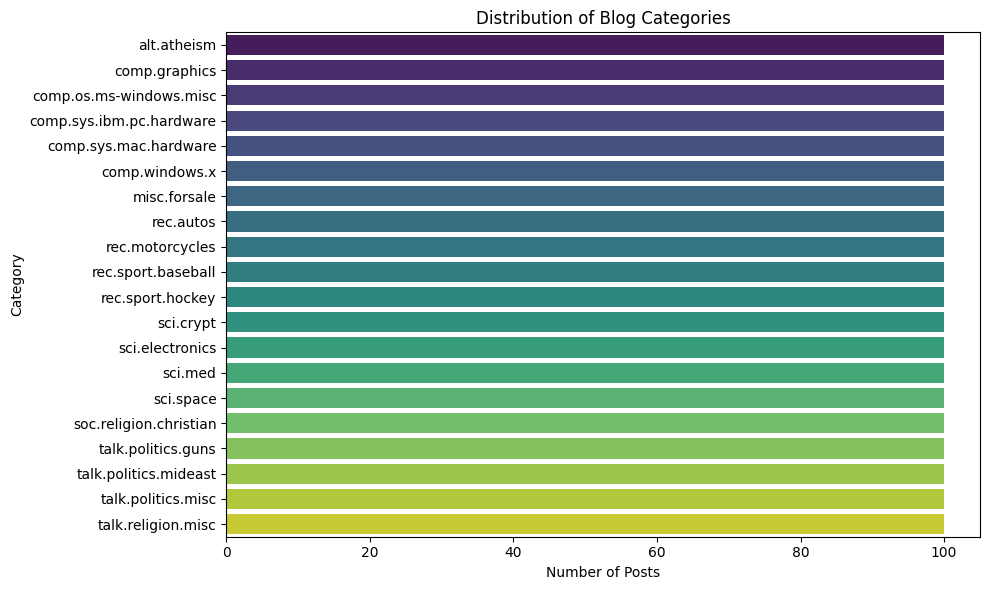

In [11]:
# Visualize the distribution of categories
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index, palette='viridis')
plt.title('Distribution of Blog Categories')
plt.xlabel('Number of Posts')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [12]:
# --- Text Preprocessing Function ---
# This function cleans text data by performing several steps:
# 1. Lowercasing: Converts all text to lowercase.
# 2. Punctuation Removal: Removes all punctuation marks.
# 3. Tokenization: Splits text into individual words.
# 4. Stopword Removal: Eliminates common words that don't carry much meaning (e.g., 'the', 'is').
# 5. Lemmatization: Reduces words to their base form (e.g., 'running' -> 'run').

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str): # Handle potential non-string entries
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return " ".join(filtered_tokens)

In [15]:
# Apply preprocessing to the 'Text' column
df['Processed_Text'] = df['Text'].apply(preprocess_text)

In [16]:
print("\n--- Text Preprocessing Complete ---")
print("First 5 rows with processed text:")
print(df[['Text', 'Processed_Text', 'Category']].head())


--- Text Preprocessing Complete ---
First 5 rows with processed text:
                                                Text  \
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....   
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...   
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...   

                                      Processed_Text     Category  
0  path cantaloupesrvcscmuedumagnesiumclubcccmued...  alt.atheism  
1  newsgroups altatheism path cantaloupesrvcscmue...  alt.atheism  
2  path cantaloupesrvcscmuedudasnewsharvardedunoc...  alt.atheism  
3  path cantaloupesrvcscmuedumagnesiumclubcccmued...  alt.atheism  
4  xref cantaloupesrvcscmuedu altatheism53485 tal...  alt.atheism  


In [17]:
# --- Feature Extraction using TF-IDF ---
# TF-IDF (Term Frequency-Inverse Document Frequency) converts text into numerical vectors.
# It reflects how important a word is to a document in a collection or corpus.

In [18]:
# Initialize TF-IDF Vectorizer
# max_features can be used to limit the number of features (words)
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting to 5000 most frequent words


In [19]:
# Fit and transform the processed text data
X = tfidf_vectorizer.fit_transform(df['Processed_Text'])
y = df['Category']

print(f"\nTF-IDF Vectorization Complete. Shape of feature matrix (X): {X.shape}")
print(f"Number of unique categories (y): {len(y.unique())}")


TF-IDF Vectorization Complete. Shape of feature matrix (X): (2000, 5000)
Number of unique categories (y): 20


In [20]:
# --- Section 3: Naive Bayes Model for Text Classification ---
# This section implements and trains a Naive Bayes classifier for text categorization.

# Split the data into training and test sets
# test_size=0.20 means 20% of the data will be used for testing, 80% for training
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"\nData split into training and test sets:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Data split into training and test sets:
X_train shape: (1600, 5000), y_train shape: (1600,)
X_test shape: (400, 5000), y_test shape: (400,)


In [21]:
# Initialize the Multinomial Naive Bayes classifier
# MultinomialNB is suitable for classification with discrete features (like word counts or TF-IDF)
naive_bayes_classifier = MultinomialNB()

In [22]:
# Train the model on the training data
print("\nTraining Naive Bayes classifier...")
naive_bayes_classifier.fit(X_train, y_train)
print("Model training complete.")


Training Naive Bayes classifier...
Model training complete.


In [23]:
# Make predictions on the test set
y_pred = naive_bayes_classifier.predict(X_test)
print("Predictions made on the test set.")

Predictions made on the test set.


In [24]:
# --- Section 4: Sentiment Analysis ---
# This section performs sentiment analysis on the original blog post texts.

# Initialize VADER Sentiment Intensity Analyzer
analyzer = SentimentIntensityAnalyzer()

In [25]:
# Function to get sentiment label based on VADER compound score
def get_vader_sentiment(text):
    if not isinstance(text, str): # Handle potential non-string entries
        return "neutral" # Default for non-text
    vs = analyzer.polarity_scores(text)
    if vs['compound'] >= 0.05:
        return 'positive'
    elif vs['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [26]:
# Apply sentiment analysis to the original 'Text' column
df['Sentiment'] = df['Text'].apply(get_vader_sentiment)

In [27]:
print("\n--- Sentiment Analysis Complete ---")
print("First 5 rows with sentiment:")
print(df[['Text', 'Sentiment', 'Category']].head())


--- Sentiment Analysis Complete ---
First 5 rows with sentiment:
                                                Text Sentiment     Category
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  negative  alt.atheism
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  positive  alt.atheism
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  negative  alt.atheism
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  negative  alt.atheism
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  positive  alt.atheism


In [28]:
# Examine the distribution of sentiments
print("\n--- Overall Sentiment Distribution ---")
print(df['Sentiment'].value_counts())


--- Overall Sentiment Distribution ---
Sentiment
positive    1334
negative     631
neutral       35
Name: count, dtype: int64


/tmp/ipython-input-29-2494934737.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='coolwarm', order=['positive', 'neutral', 'negative'])


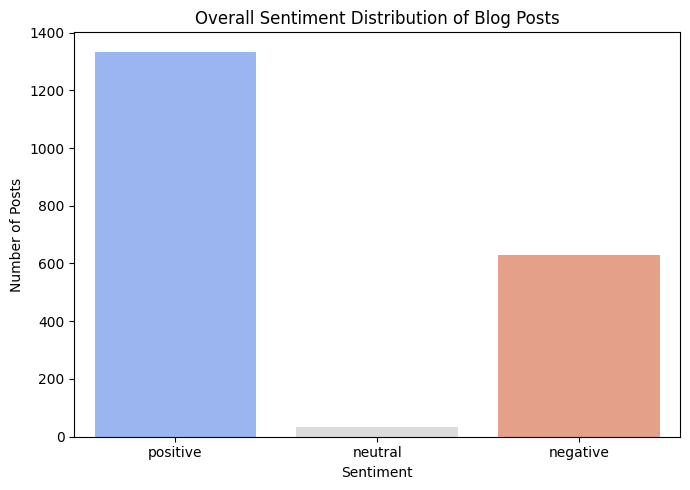

In [29]:
# Visualize overall sentiment distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='Sentiment', data=df, palette='coolwarm', order=['positive', 'neutral', 'negative'])
plt.title('Overall Sentiment Distribution of Blog Posts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

In [30]:
# Examine the distribution of sentiments across different categories
print("\n--- Sentiment Distribution Across Categories ---")
sentiment_by_category = df.groupby('Category')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)
print(sentiment_by_category)


--- Sentiment Distribution Across Categories ---
Sentiment                 negative  neutral  positive
Category                                             
alt.atheism                   0.42     0.01      0.57
comp.graphics                 0.13     0.04      0.83
comp.os.ms-windows.misc       0.24     0.02      0.74
comp.sys.ibm.pc.hardware      0.21     0.00      0.79
comp.sys.mac.hardware         0.24     0.03      0.73
comp.windows.x                0.20     0.02      0.78
misc.forsale                  0.07     0.08      0.85
rec.autos                     0.27     0.01      0.72
rec.motorcycles               0.30     0.02      0.68
rec.sport.baseball            0.27     0.01      0.72
rec.sport.hockey              0.28     0.01      0.71
sci.crypt                     0.29     0.00      0.71
sci.electronics               0.18     0.04      0.78
sci.med                       0.38     0.01      0.61
sci.space                     0.32     0.03      0.65
soc.religion.christian        0.

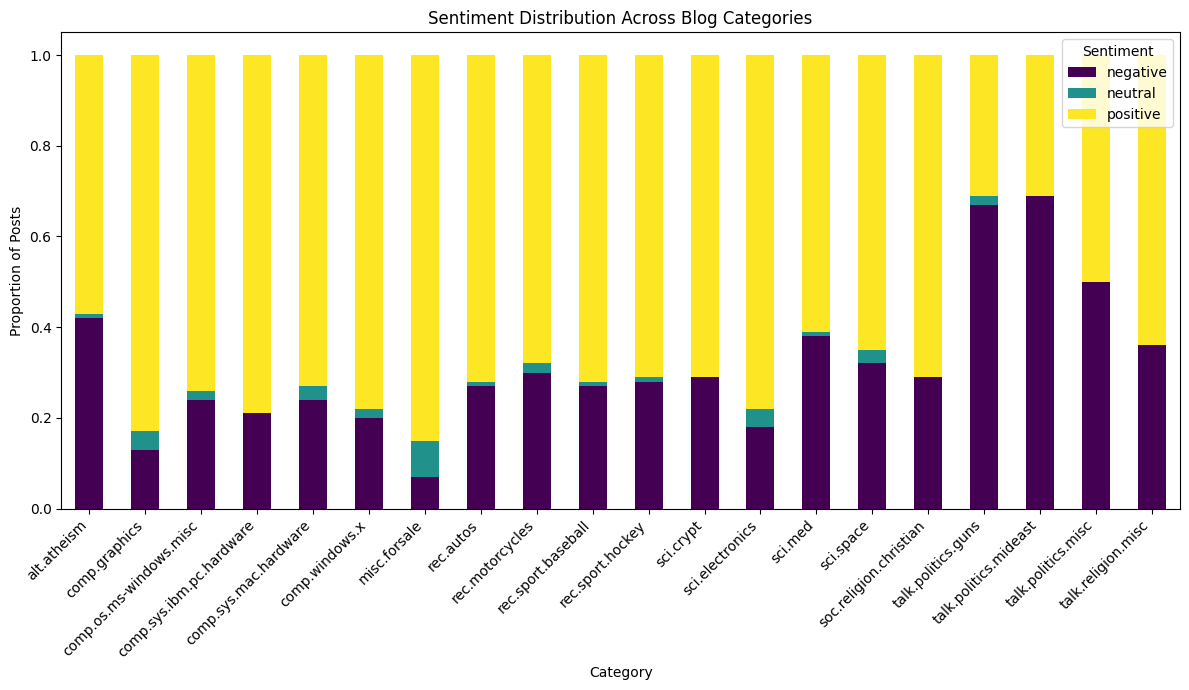

In [31]:
# Visualize sentiment distribution across categories
sentiment_by_category.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Sentiment Distribution Across Blog Categories')
plt.xlabel('Category')
plt.ylabel('Proportion of Posts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


--- Naive Bayes Classifier Evaluation ---
Accuracy: 0.8050
Precision (weighted): 0.8122
Recall (weighted): 0.8050
F1-Score (weighted): 0.8026

--- Classification Report ---
                          precision    recall  f1-score   support

             alt.atheism       0.75      0.75      0.75        20
           comp.graphics       0.81      0.85      0.83        20
 comp.os.ms-windows.misc       0.80      0.80      0.80        20
comp.sys.ibm.pc.hardware       0.52      0.70      0.60        20
   comp.sys.mac.hardware       0.81      0.65      0.72        20
          comp.windows.x       0.83      0.75      0.79        20
            misc.forsale       0.86      0.95      0.90        20
               rec.autos       0.90      0.95      0.93        20
         rec.motorcycles       0.90      0.90      0.90        20
      rec.sport.baseball       0.91      1.00      0.95        20
        rec.sport.hockey       1.00      1.00      1.00        20
               sci.crypt       0.

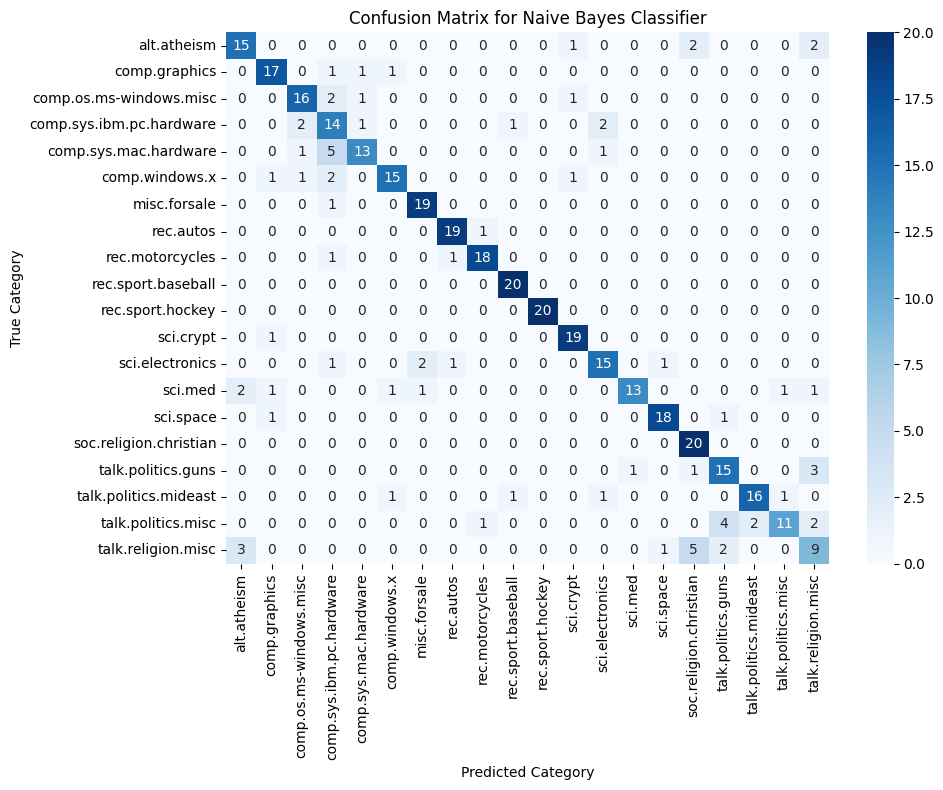

In [32]:
# --- Section 5: Evaluation ---
# This section evaluates the performance of the Naive Bayes classifier
# and discusses the sentiment analysis results.

print("\n--- Naive Bayes Classifier Evaluation ---")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

# Display a detailed classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, zero_division=0))

# Display the confusion matrix
print("\n--- Confusion Matrix ---")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=naive_bayes_classifier.classes_,
            yticklabels=naive_bayes_classifier.classes_)
plt.title('Confusion Matrix for Naive Bayes Classifier')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.tight_layout()
plt.show()


In [33]:
# --- Discussion of Model Performance and Challenges ---
print("\n--- Discussion: Naive Bayes Model Performance ---")
print("The Naive Bayes classifier achieved an accuracy of {:.2f}%.".format(accuracy * 100))
print("The precision, recall, and F1-score provide a more nuanced view of the model's performance across different categories.")
print("A high F1-score indicates a good balance between precision and recall.")
print("\nChallenges encountered:")
print("- **Text Complexity:** Blog posts can contain diverse language, slang, and domain-specific terminology, which might not be fully captured by basic TF-IDF or general stopwords.")
print("- **Class Imbalance:** If some categories have significantly fewer posts than others, the model might struggle to accurately classify minority classes. (Check `df['Category'].value_counts()` for this).")
print("- **Naive Bayes Assumption:** Naive Bayes assumes independence of features (words), which is rarely true in natural language. Despite this, it often performs surprisingly well.")
print("- **Preprocessing Impact:** The choice of preprocessing steps (e.g., lemmatization vs. stemming, specific stopword list) can significantly impact performance.")





--- Discussion: Naive Bayes Model Performance ---
The Naive Bayes classifier achieved an accuracy of 80.50%.
The precision, recall, and F1-score provide a more nuanced view of the model's performance across different categories.
A high F1-score indicates a good balance between precision and recall.

Challenges encountered:
- **Text Complexity:** Blog posts can contain diverse language, slang, and domain-specific terminology, which might not be fully captured by basic TF-IDF or general stopwords.
- **Class Imbalance:** If some categories have significantly fewer posts than others, the model might struggle to accurately classify minority classes. (Check `df['Category'].value_counts()` for this).
- **Naive Bayes Assumption:** Naive Bayes assumes independence of features (words), which is rarely true in natural language. Despite this, it often performs surprisingly well.
- **Preprocessing Impact:** The choice of preprocessing steps (e.g., lemmatization vs. stemming, specific stopword list

In [34]:
# --- Reflection on Sentiment Analysis Results ---
print("\n--- Reflection: Sentiment Analysis Results ---")
print("The overall sentiment distribution shows the general emotional tone of the blog posts.")
print("Analyzing sentiment across categories can reveal interesting insights:")
print("- Categories with a higher proportion of positive sentiment might indicate topics that are generally well-received or discuss positive experiences.")
print("- Categories with more negative sentiment could point to discussions about challenges, criticisms, or sensitive issues.")
print("- Neutral sentiment might indicate factual, descriptive, or less emotionally charged content.")
print("The VADER lexicon is tuned for social media text, which might be a limitation for more formal blog posts, potentially leading to a higher proportion of 'neutral' sentiments if the language is not highly emotional.")
print("These insights can help in understanding the content's nature and audience reception within different thematic areas.")




--- Reflection: Sentiment Analysis Results ---
The overall sentiment distribution shows the general emotional tone of the blog posts.
Analyzing sentiment across categories can reveal interesting insights:
- Categories with a higher proportion of positive sentiment might indicate topics that are generally well-received or discuss positive experiences.
- Categories with more negative sentiment could point to discussions about challenges, criticisms, or sensitive issues.
- Neutral sentiment might indicate factual, descriptive, or less emotionally charged content.
The VADER lexicon is tuned for social media text, which might be a limitation for more formal blog posts, potentially leading to a higher proportion of 'neutral' sentiments if the language is not highly emotional.
These insights can help in understanding the content's nature and audience reception within different thematic areas.


In [35]:
# --- Section 6: Conclusion ---
print("\n--- Conclusion ---")
print("This notebook successfully demonstrated the process of text classification using the Naive Bayes algorithm and sentiment analysis on the 'blogs_categories.csv' dataset.")
print("Data preprocessing, feature extraction with TF-IDF, model training, and evaluation were performed.")
print("Sentiment analysis provided insights into the emotional tone of the blog posts, both overall and within specific categories.")
print("The results highlight the practical application of NLP techniques for categorizing and understanding textual data.")



--- Conclusion ---
This notebook successfully demonstrated the process of text classification using the Naive Bayes algorithm and sentiment analysis on the 'blogs_categories.csv' dataset.
Data preprocessing, feature extraction with TF-IDF, model training, and evaluation were performed.
Sentiment analysis provided insights into the emotional tone of the blog posts, both overall and within specific categories.
The results highlight the practical application of NLP techniques for categorizing and understanding textual data.
